[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module2_Files/3_BackProp_and_ReLU.ipynb)

#  Learning an entire dataset with forward and backpropagation with nonlinear activation functions
-----------------------------------------
**Dr. Dave Wanik - University of Connecticut - Department of Operations and Information Management**

You almost have everything you need to understand how a neural network fits! Now let's kick it up a notch and see how we can include nonlinearity into the mix via the `relu` activation and learn an entire dataset.

In [ ]:
# get some important modules
import pandas as pd # for data wrangling
import numpy as np # for array calculations, some math functions
from matplotlib import pyplot as plt #for plotting

In [ ]:
# some modules for neural nets
from keras.models import Sequential
from keras.layers import Dense

# Read and Prepare Data

Let's read some nice dummy data for this example. Some basic categorical data for a classification problem.

In [ ]:
# # step 1: copy & paste the shared link you will get from Google Drive
# URL = 'https://drive.google.com/file/d/1rVwxy0fd-9aM2Dvw8_42hWoZ7upZE0jt/view?usp=sharing'

# # step 2: copy & paste the command below (this part of the command is fixed)
# fixed_path = 'https://drive.google.com/uc?export=download&id='

# # step 3: Extract the file ID from the URL (this part of the command is fixed)
# file_path = URL.split('/')[-2]

# # retrieve the CSV data and build a dataframe
# df = pd.read_csv(fixed_path + file_path)

# # print the shape and dataset info
# print(df.shape)
# df.info()

(14, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Day       14 non-null     int64 
 1   Temp      14 non-null     object
 2   Humidity  14 non-null     object
 3   Wind      14 non-null     object
 4   Play      14 non-null     object
dtypes: int64(1), object(4)
memory usage: 688.0+ bytes


In [ ]:
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module2_Files/Tennis%20Binary%20Classification%20Binary.csv"

# retrieve the CSV data and build a dataframe
df = pd.read_csv(url)

# print the shape and dataset info
print(df.shape)
df.info()

(14, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Day       14 non-null     int64 
 1   Temp      14 non-null     object
 2   Humidity  14 non-null     object
 3   Wind      14 non-null     object
 4   Play      14 non-null     object
dtypes: int64(1), object(4)
memory usage: 692.0+ bytes


But computers can't 'read' categorical data! We will need to recode to something a computer can understand and perform mathematical operations on.

We will create dummy variables of 0s and 1s for the X data and we are predicting if people played golf or not.

In [ ]:
# imagine our data was of this form
df.head()

,Day,Temp,Humidity,Wind,Play
0,1,Hot,High,Weak,no
1,2,Hot,High,Strong,no
2,3,Hot,High,Weak,yes
3,4,Cool,High,Weak,yes
4,5,Cool,Normal,Weak,yes


In [ ]:
df_one = pd.get_dummies(data=df, columns=['Temp', 'Humidity', 'Wind', 'Play'])

tmp = pd.concat((df_one, df), axis=1)
golf = tmp.iloc[:, [0,2,4,6,8]]
del golf['Day']
golf

,Temp_Hot,Humidity_Normal,Wind_Weak,Play_yes
0,1,0,1,0
1,1,0,0,0
2,1,0,1,1
3,0,0,1,1
4,0,1,1,1
5,0,1,0,0
6,0,1,0,1
7,1,0,1,0
8,0,1,1,1
9,0,1,1,1


In [ ]:
# rename all columns except Day
golf = golf.rename(columns={'Temp_Hot': 'Temp',
                                'Humidity_Normal': 'Humidity',
                                'Wind_Weak': 'Wind',
                                'Play_yes': 'Play',})
golf

,Temp,Humidity,Wind,Play
0,1,0,1,0
1,1,0,0,0
2,1,0,1,1
3,0,0,1,1
4,0,1,1,1
5,0,1,0,0
6,0,1,0,1
7,1,0,1,0
8,0,1,1,1
9,0,1,1,1


This notebook considers how a network learns an entire dataset. Consider you are a big fan of golf. You can decide whether or not to play by watching the weather. Which weather combinations indicate when folks are playing?

To solve this problem, you might record the temperature, humidity and wind speed observing the correlation between each weather and playing golf.

Since neural networks do not read the pattern of weather, we have to translate the weather into math. What you really want to do is mimic the pattern of the weather inform of numbers. Notice that the pattern of numbers shown here mimics the pattern from the weather in the form of 0s and 1s. Each weather condition (temperature, humidity and wind speed) gets a column. Notice also that there are 14 rows representing the 14 different observed weather.

# Refresher: Learning One Row of Data

You have converted the weather pattern into a matrix ( with just 0s and 1s). Now let’s create that matrix in Python so the neural network can read it. What do you want the neural network to do? Take the weather matrix and learn to transform it into the play_vs_noplay matrix. More important, you want the neural network to take any matrix containing the same underlying pattern as weather and transform it into a matrix that contains the underlying pattern of play_vs_noplay.

In [ ]:
# building a neural network

import numpy as np

# let's choose some random initial values for the weights
weights = np.array([0.52,0.18,-0.12])
alpha = 0.1 # some small number, a learning rate

# X data
X = golf.loc[:, ['Temp', 'Humidity', 'Wind']] # select temp, humidity and wind as inputs
X = np.array(X.values.tolist()) # generate those values in array

# y data
y = np.array(golf['Play'].tolist()) # convert play in array

# specify one row of data to predict - scroll up and check the df.head() to confirm
input = X[0] # [1,0,1] # select the first row
target_var = y[0] # 0 means no play

print('this is the first row of data:', input)
print('this is the target variable for first row:', target_var)

this is the first row of data: [1 0 1]
this is the target variable for first row: 0


Remember PEDW:
* make a prediction
* calculate the (squared) error
* calculate weight delta (direction and amount)
* update the weight (weights get adjusted such that we make a more accurate prediction next time!)

If we previously overestimated, weights need to get smaller (more negative). If we previously underestimated, the weights need to get bigger (more positive.)

In [ ]:
# let's fit the model
my_weights = []
my_error = []
for iteration in range(20):
    prediction = input.dot(weights)
    error = (target_var - prediction) ** 2
    delta = prediction - target_var
    weights = weights - (alpha * (input * delta))
    my_weights.append(weights)
    my_error.append(error)
    print("Error:" + str(error) + " Prediction:" + str(prediction))

Error:0.16000000000000003 Prediction:0.4
Error:0.10239999999999996 Prediction:0.31999999999999995
Error:0.065536 Prediction:0.256
Error:0.041943039999999994 Prediction:0.20479999999999998
Error:0.026843545599999994 Prediction:0.16383999999999999
Error:0.017179869183999993 Prediction:0.13107199999999997
Error:0.010995116277759998 Prediction:0.1048576
Error:0.0070368744177663955 Prediction:0.08388607999999997
Error:0.004503599627370488 Prediction:0.06710886399999993
Error:0.0028823037615171095 Prediction:0.053687091199999926
Error:0.001844674407370952 Prediction:0.04294967295999996
Error:0.0011805916207174108 Prediction:0.03435973836799999
Error:0.0007555786372591429 Prediction:0.027487790694399994
Error:0.0004835703278458524 Prediction:0.021990232555520017
Error:0.00030948500982134634 Prediction:0.017592186044416036
Error:0.00019807040628566102 Prediction:0.014073748835532807
Error:0.00012676506002282206 Prediction:0.011258999068426201
Error:8.112963841460532e-05 Prediction:0.0090071992

Of course, we know error goes down as we train. This smooth and gentle curve is a hallmark of a model that isn't training too quickly (training to quickly might lead to overfitting!)

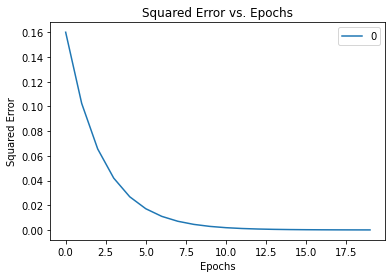

In [ ]:
my_error = pd.DataFrame(my_error)
my_error.plot()
plt.xlabel('Epochs')
plt.ylabel('Squared Error')
plt.title('Squared Error vs. Epochs')
plt.show()

Let's investigate how the weights changed... how come only the second weight was updated?! It's because it was the only one that had an input!

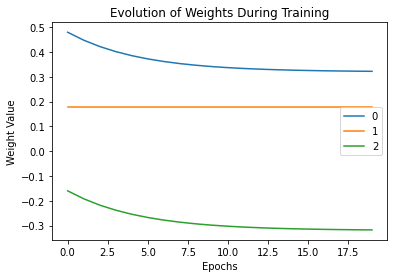

In [ ]:
# see how the value of the weights changed?
my_weights = pd.DataFrame(my_weights)
my_weights.plot()
plt.xlabel('Epochs')
plt.ylabel('Weight Value')
plt.title('Evolution of Weights During Training')
plt.show()

💡Recall the PEDW code... you scale the weight by the input... so if the input is ZERO - no weight update! This is because it did not send any information forward across the network... so why would you update it's weight?! This one really is a lightbulb moment... this explains why the orange line is flat for input data of [1,0,1]... a 0 means no information was sent!

## Building Our Neural Network

This code example may bring back several nuances you learned in Chapter 3 of Trask. First, the use of the dot function was a way to perform a dot product (weighted sum) between two vectors. But not included in Chapter 3 was the way NumPy matrices can perform elementwise addition and multiplication.

In [ ]:
import numpy as np

a = np.array([0,1,2,1])
b = np.array([2,2,2,3])

print(a*b) # elementwise multiplication
print(a+b) # elementwise addition
print(a * 0.5) # vector-scalar multiplication: each element multiplied by a constant
print(a + 0.5) # vector-scalar addition: each element has constant added to it

[0 2 4 3]
[2 3 4 4]
[0.  0.5 1.  0.5]
[0.5 1.5 2.5 1.5]


# Learning the whole dataset!

In the previous example, you have trained neural networks that learned how to model a single training example (input ▶ target_variable pair). But now you’re trying to build a neural network that tells you whether it is a play. You need it to know more than one weather. How do you do this? You train it on all the weather data at once.

Below is a wonderful example of **stochastic gradient descent** - the weights are updated after every single row! You should be able to tell this is stochastic gradient descent just by looking at the code.

In [ ]:
import numpy as np

# feel free to try other values!
weights = np.array([0.5,0.48,-0.7])
# feel free to try other values!
alpha = 0.1

# X data
X = golf.loc[:, ['Temp', 'Humidity', 'Wind']] # select temp, humidity and wind as inputs
X = np.array(X.values.tolist()) # generate those values in array

# y data
y = np.array(golf['Play'].tolist()) # convert play in array

# a place to store results (so we can graph later!)
my_weights = []
my_error = []

for iteration in range(100): # train for 100 epochs!
    error_for_all = 0 # a place to store sq. error after each observation
    for row_index in range(len(y)):
        input = X[row_index]
        target_var = y[row_index]

        prediction = input.dot(weights)

        error = (target_var - prediction) ** 2
        # check track of the squared error
        error_for_all += error

        delta = prediction - target_var
        weights = weights - (alpha * (input * delta))
        print("Prediction:" + str(prediction))


    print("Error:" + str(error_for_all) + "\n")
    my_error.append(error_for_all)
    # store results
    my_weights.append(weights)

Prediction:-0.19999999999999996
Prediction:0.52
Prediction:-0.2119999999999999
Prediction:-0.5588
Prediction:0.07708000000000004
Prediction:0.572292
Prediction:0.5150628
Prediction:0.2785720000000001
Prediction:0.22507132000000002
Prediction:0.380057056
Prediction:0.7030436824
Prediction:0.0
Prediction:1.09508407656
Prediction:0.0
Error:7.78333509587159

Prediction:0.34332794708799996
Prediction:0.5175015976352
Prediction:0.22291219790688
Prediction:-0.165130459755488
Prediction:0.6746134927240608
Prediction:0.7557695572315939
Prediction:0.6801926015084345
Prediction:0.5273814550286466
Prediction:0.6433564328023811
Prediction:0.7146851462419048
Prediction:0.7763691834531624
Prediction:0.0
Prediction:1.2848332712263348
Prediction:0.0
Error:4.744288331517291

Prediction:0.4291343518732218
Prediction:0.41932531026817166
Prediction:0.3013749504717603
Prediction:-0.006155323816770253
Prediction:0.8647091465501194
Prediction:0.7837780233302007
Prediction:0.7054002209971807
Prediction:0.55524

## Visualize your results

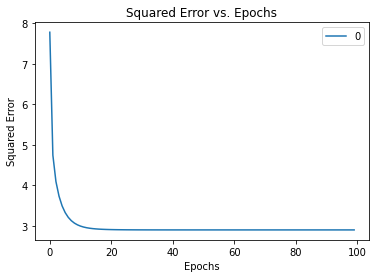

In [ ]:
my_error = pd.DataFrame(my_error)
my_error.plot()
plt.xlabel('Epochs')
plt.ylabel('Squared Error')
plt.title('Squared Error vs. Epochs')
plt.show()

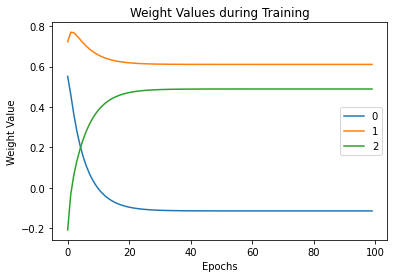

In [ ]:
# see how the value of the weights changed?
my_weights = pd.DataFrame(my_weights)
my_weights.plot()
plt.xlabel('Epochs')
plt.ylabel('Weight Value')
plt.title('Weight Values during Training')
plt.show()

Don't you love the wiggly lines? Your model LEARNED an entire dataset! THAT IS AWESOME! Error goes to zero but plateaus around 3 (this happens in the real-world.)

Your model is updating its weights to make an accurate prediction for all 14 rows of data.
.
While this sort of looks like a nonlinear weight update (because of the wiggly lines),  we haven't truly introduced what makes a neural network truly nonlinear, which is the inclusion of activation functions in the hidden layers... coming soon!

**On Your Own:** See if you can keep track of the predictions during each iteration and make a plot of accuracy. Make a confusion matrix or classification report after each epoch.

## The Various Types of Gradient Descent

1.   **Stochastic**: Learning "one example at a time" is a variant on Gradient Descent called Stochastic Gradient Descent, and it is one of the handful of methods that can be used for learning an entire dataset. This is the example we use in this notebook.
2.   **Full**: Instead of updating the weights once for each training example, the network simply calculates the average weight_delta over the entire dataset, only actual y changing the weights each time it computes a full average.
3.   **Batch**: Instead of updating the weights after just one or after the entire dataset of examples, you choose a "batch size" (typical y between 8 and 256) after which the weights are updated.




**On Your Own:** We will focus on stochastic gradient descent in this notebook. You can try to update the code to account for full and batch gradient descent by hand and compare!

### so... which one should I use?
Like all good questions: it depends.

* Stochastic means you will be updating the weights A LOT - so every row in X gets a say in the weight updates immediately as it's seen by the model. Stochastic can also be associated with the word 'random' - which makes sense since there may be some random noise that you are fitting on when looking at each row.  Stochastic gradient descent (SGD) means you will be updating A LOT of weights. You may nitpick and focus on each row instead of going for general trends and may underfit or overfit.
* Full means you update the weights after looking at ALL the rows - so less weights to update, but you might not find the optimal combinations of weights. This type of gradient descent will run the fastest and it should be obvious to you why this is!
* Batch splits the difference between stochastic and full. You can update the weights after every N rows - but value of N to use? It depends on your data and model architecture - it's a hyperparameter that you get to update.

## Neural Networks Learn Correlation Between Input and Output

We just got done training a single-layer neural network to take a weather pattern and identify whether people will play golf or not.

Let's take on the neural network's perspective for a moment. The neural network doesn't know that it was processing weather data. All it was trying to do was identify which input (out of the 3 possible) correlated with the output.

It updates the weight to correlate (relate) the input to the output.



# Learning Indirect Correlation

... but what if there is no clear or obvious pattern relating the input to the output?

If your data does NOT have direct correlation, you should create intermediate data that does. In reality, neural networks search for correlation between their input and output layers. You set the values of the input layer to be individual rows of the input data, and you try to train the network (update weights) so that the output layer equals the output dataset. The neural network doesn’t know about data (neural networks aren't 'smart'.) - NNs just search for correlation between the input and output layers.

💡 Now we are starting to talk about hidden layers in earnest 😀  Let's use two set of weights in our network. The first one will create an intermediate dataset that has indirect correlation with our output (where we will introduce a nonlinear activation function). The second will then use that indirect correlation to correctly predict our output with a linear activation function (so that it can take on any value.)

# No difference between these dot products

### Three layer example
There are two mathematical operations using three layers:
* `np.dot(a,b)`
* `np.dot(tmp,c)`

In [ ]:
a = [-5, 1, 3, -7, 2]

b = [[2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2]] # make this a 5x5 matrix!

c = [[3],
     [3],
     [3],
     [3],
     [3]] # make this a 5x1 matrix!

tmp = np.dot(a,b)
tmp = np.dot(tmp,c)
tmp

array([-180])

### Two layer example
There is one mathematical operations using two layers:
* `np.dot(a,b)`

... yet we get the same answer. So why bother having a third layer?

In [ ]:
a = [-5, 1, 3, -7, 2]

b = [[30],
     [30],
     [30],
     [30],
     [30]] # make this a 5x1 matrix!
np.dot(a,b)

array([-180])

### Same answer, but with less layers... what can we do?
It's a linear combination - so we can do whatever we need to do with two layers instead of three. Those multiple sets of dot products are no different than multiply 2*3*4 or just multiplying 2*12... the latter is simpler, takes less time, and is accurate - so you should use that one!

We will need nonlinearity in order to have any value from stacking layers so that we can learn 'indirect correlation' where the input sometimes correlates to the output and sometimes does not.

This is where activation functions come in!

# Nonlinearity and activation functions (ReLU!)
[Recified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLU) is just one of several activation functions we will get to know during our class. It is one of the simplest functions and very important for allowing our model to learn nonlinear patterns.

![relu](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)

**Figure:** An image showing how ReLU recodes values - if the value is less than 0, it gets recoded to 0. Otherwise, return x.

In [ ]:
# original data
a = [-5, 1, 3, -7, 2]
# relu function! if it's negative, return a 0, otherwise, return original value
np.maximum(a, 0)

array([0, 1, 3, 0, 2])

a      : [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11]
ReLU(a): [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]


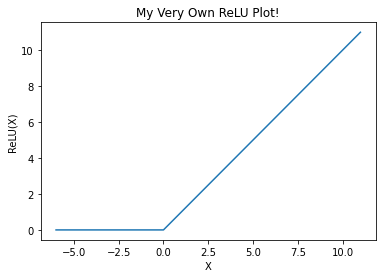

In [ ]:
# make your own ReLU plot!
a = np.arange(-6,12,1)
print('a      :', a)
# relu function! if it's negative, return a 0, otherwise, return original value
b = np.maximum(a, 0)
print('ReLU(a):', b)
plt.plot(a,b)
plt.title('My Very Own ReLU Plot!')
plt.xlabel('X')
plt.ylabel('ReLU(X)')
plt.show()

ReLU simply recodes a value to zero if it has a negative number. This simple activation function (and others like it) are responsible for allowing neural networks to learn in a nonlinear way.

# Our First "Deep" Neural Network

The following code initializes the weights and makes a forward propagation. Our first neural network with its 16 (12 + 4) neuron weights and 4 hidden units in the hidden layer.

In [ ]:
!pip3 install keras-visualizer
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation
from keras_visualizer import visualizer
from keras import layers

model = models.Sequential()
model.add(Dense(4, input_shape=(3,))) # the 4 is for the number of hidden layers, the 3 is size of the input data
model.add(Dense(1))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model.summary() # inspect for output shapes and trainable parameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
visualizer(model, format='png', view=True)

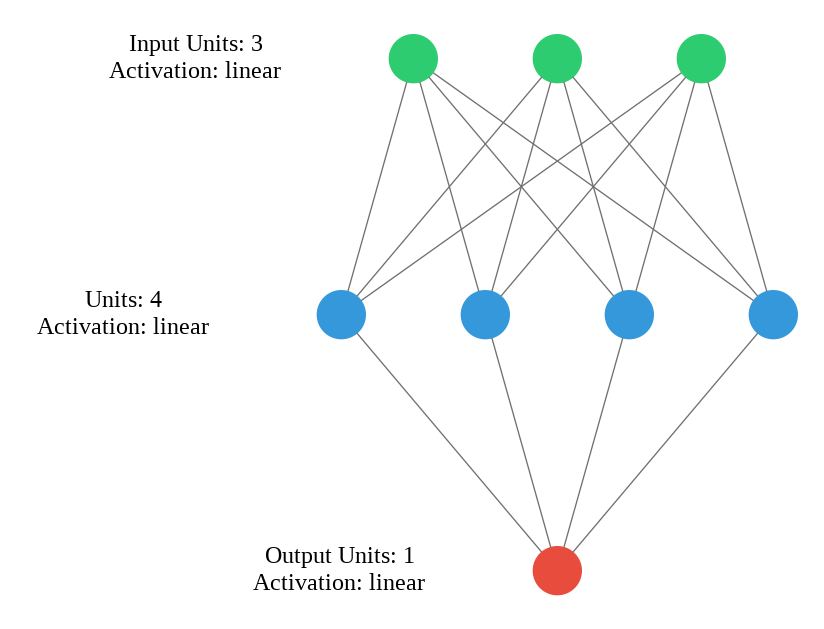

## What ReLU does during Forward Propagation

In [ ]:
import numpy as np

np.random.seed(1)

# 1. Initializing the network's weights and data
def relu(x):
    return (x > 0) * x # returns x if x > 0
                       # return 0 otherwise

def relu2deriv(output):
    return output>0 # returns 1 for input > 0
                    # return 0 otherwise

# X data
X = golf.loc[:, ['Temp', 'Humidity', 'Wind']] # select temp, humidity and wind as inputs
X = np.array(X.values.tolist()) # generate those values in array

# y data
y = np.array(golf['Play'].tolist()).T

alpha = 0.1 # learning rate
hidden_size = 4 # 4 hidden units in the hidden layer

# input/target variable
input = X[0:1] # first row of X
target_var = y[0:1]

# randomly initialize the weights to start
weights_0_1 = 2*np.random.random((3,hidden_size))-1 # this is the number of columns in X (you don't have to hardcode)
weights_1_2 = 2*np.random.random((hidden_size,1))-1

# 2. PREDICT + COMPARE: Making a prediction, and calculating the output error and delta
# 3. LEARN: Backpropagation from layer_2 to layer_1

# P
layer_0 = input
layer_1 = np.dot(layer_0,weights_0_1)
print('layer_1 before RELU:', layer_1)
layer_1 = relu(layer_1)
print('layer_1 after RELU:', layer_1)
layer_2 = np.dot(layer_1,weights_1_2)

layer_1 before RELU: [[-0.37242104  0.51828245 -1.16138222 -0.02489585]]
layer_1 after RELU: [[-0.          0.51828245 -0.         -0.        ]]


Seehow the negative values were turned to 0s?! Note that `relu` is only used between hidden layers - you don't use `relu` going to `layer_2` (the output layer). We will eventually use different activation functions there.

Note that the only node that is going to communicate ANY information to the output is node2 (0.51). The rest are 0s! All inputs (temp, wind, humidity) contributed to node2.

In [ ]:
# layer 2
print('prediction:', layer_2)
print('target variable:', y[0])

prediction: [[0.39194327]]
target variable: 0


Looks like we overestimated! Let's use this error feedback signal to update our model.

## Using ReLU During Backpropagation
We are working ourselves backwards from prediction to input and updating the weights as we go!

## Updating `weights_1_2`
We need to update our weights - we overestimated!  Positive weights need to get smaller (more negative), and negative weights need to become more negative.

`layer_2_delta` is easy - it's just actual minus predicted.

In [ ]:
# E (remember - this is just used for tracking model fit)
error = (layer_2-target_var)**2
print('error:', error)
# D (direction and amount)
# this tells the model "I overestimated, make positive weights smaller"
layer_2_delta=(layer_2-target_var) # [1,1] shape

print('layer_2_delta:', layer_2_delta)

error: [[0.15361952]]
layer_2_delta: [[0.39194327]]


And it would be fine to update layer_2 weights at this point.

In [ ]:
weights_1_2

array([[-0.5910955 ],
       [ 0.75623487],
       [-0.94522481],
       [ 0.34093502]])

In [ ]:
weight_delta_1_2 = layer_1.T.dot(layer_2_delta)
print('weight_delta_1_2: \n', weight_delta_1_2)

weight_delta_1_2: 
 [[0.        ]
 [0.20313732]
 [0.        ]
 [0.        ]]


Remember that node2 of layer1 was the only node to pass some information... hence, it's the only weight in weight1_2 that should be updated!

In [ ]:
print('before: \n', weights_1_2)
print('\n')
weights_1_2 -= alpha * weight_delta_1_2
print('after: \n', weights_1_2) # weight2 gets smaller! the rest stay the same

before: 
 [[-0.5910955 ]
 [ 0.75623487]
 [-0.94522481]
 [ 0.34093502]]


after: 
 [[-0.5910955 ]
 [ 0.73592114]
 [-0.94522481]
 [ 0.34093502]]


What you see is that the 0.75 weight (in the second node) has become a 0.73 - it got smaller! This makes sense because our model overpredicted by 0.39 so we need to make the weights smaller.

And which weight got smaller? The one that previously contributed information. The first, third and fourth weight didn't contribute any information to the prediction because the values in layer_1 were 0s for these!

In [ ]:
# see? only the second node in layer1 had any info to pass to the prediction
layer_1

array([[-0.        ,  0.51828245, -0.        , -0.        ]])

## Updating `weights_0_1`

We already know `layer_2_delta` has a [1,1] shape - it is just a constant (0.39). It tells our model we overestimated by 0.39! Let's use this information as a feedback signal to create `layer_1_delta` and update the `weights_0_1`.

🛑 This is more involved than the previous weight update. Pay attention and make sure you work the math out by hand to confirm your understanding.

## weights_1_2 helps update weights_0_1

As a refresher, here are the weights_1_2 (from layer 1 to layer 2 prediction layer)

* The second and fourth weights are positive (which means any input into the seocnd and fourth unit would result in a larger output (think of a positive number times a positive number!)
  * Recall that we just overestimated. As such, we should make any input that comes into these weights less positive (so that the prediction gets smaller).

* The first and third weights are negative (which means any input into the first and third node would result in a smaller output (think of a positive number times a negative number!)
  * Again, recall that we just overestimated by 0.39. As such, we should make any input that comes into these weights more negative (so that the prediction gets less positive).


In [ ]:
weights_1_2.T

array([[-0.5910955 ,  0.73592114, -0.94522481,  0.34093502]])

But also recall that it was the second node in `weights_1_2` that contributed any information. Hence, only weights that touched the second node should be updated.

In [ ]:

# 4. LEARN: Generating weight_deltas, and updating weights
# W

# i added spaces here to make it line up nicely

# this tells the model "I overestimated, make positive weights smaller"
print('layer_1                        :', layer_1)

layer_1_delta=layer_2_delta.dot(weights_1_2.T)
print('layer_1_delta before relu2deriv:', layer_1_delta)

layer_1_delta = layer_1_delta*relu2deriv(layer_1)
print('layer_1_delta after relu2deriv :', layer_1_delta)

layer_1                        : [[-0.          0.51828245 -0.         -0.        ]]
layer_1_delta before relu2deriv: [[-0.2316759   0.28843934 -0.3704745   0.13362719]]
layer_1_delta after relu2deriv : [[-0.          0.28843934 -0.          0.        ]]


See the 0.288 and the 0.133 in `layer_1_delta before relu2deriv`? These correspond to how we would decrease positive weights by this amount - these weights in weight_1_2 were positive, so the model wants to literally make the output smaller because we had overestimated!

But that fourth weight in `weights_1_2` wasn't used in the prediction because the fourth unit in layer_1 was 0 (thanks to relu!). Hence, we will only update weights that touch node2 in layer_1.

This is why 0.288 is the only value in `layer_1_delta` - we are going to use this value to update only the weights that touched the second unit of `layer_1`.

❗ Take a breath and know that we are crushing it at this point - we know the model overestimated. And we are only going to update the weights that affected node2 of layer1 - these are the only input/weight pairs that contributed any information to the model! Leave the other weights alone.

In [ ]:
# now update the weights using the deltas!
# these have the same shape as weights_1_2 and weights_0_1

weight_delta_0_1 = layer_0.T.dot(layer_1_delta)
print(weight_delta_0_1)


[[0.         0.28843934 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.28843934 0.         0.        ]]


**On Your Own:** Looking at this matrix, you should be able to tell that you are updating the weights from Temperature to Node2 and Humidity to Node2! Draw this and show how the weights change!

In [ ]:
# now update the weights with subtraction!
weights_0_1 -= alpha * weight_delta_0_1
print(weights_0_1)

[[-0.16595599  0.41180505 -0.99977125 -0.39533485]
 [-0.70648822 -0.81532281 -0.62747958 -0.30887855]
 [-0.20646505  0.04878953 -0.16161097  0.370439  ]]


If you scroll up, you will see that the weights have gotten smaller in weights_0_1!

# One Iteration of Backpropagation (with ReLU) for one row of data

For completeness, here is a code that completes one iteration of backpropagation for one row of data. You can add print statements to check your work.

In [ ]:
import numpy as np

np.random.seed(1)

# 1. Initializing the network's weights and data
def relu(x):
    return (x > 0) * x # returns x if x > 0
                       # return 0 otherwise

def relu2deriv(output):
    return output>0 # returns 1 for input > 0
                    # return 0 otherwise

# X data
X = golf.loc[:, ['Temp', 'Humidity', 'Wind']] # select temp, humidity and wind as inputs
X = np.array(X.values.tolist()) # generate those values in array

# y data
y = np.array(golf['Play'].tolist()).T

alpha = 0.1 # learning rate
hidden_size = 4 # 4 hidden units in the hidden layer

# randomly intialize the weights (between -1 and +1 so we don't have divergence)
weights_0_1 = 2*np.random.random((3,hidden_size))-1 # this is the number of columns in X (you don't have to hardcode)
weights_1_2 = 2*np.random.random((hidden_size,1))-1

# input/target variable
input = X[0:1] # first row of X
target_var = y[0:1]


# 2. PREDICT + COMPARE: Making a prediction, and calculating the output error and delta
# 3. LEARN: Backpropagation from layer_2 to layer_1

# P
layer_0 = input # first row of X
layer_1 = np.dot(layer_0,weights_0_1)
layer_1 = relu(layer_1)
layer_2 = np.dot(layer_1,weights_1_2)

# E
error = (layer_2-target_var)**2

# D
layer_2_delta=(layer_2-target_var)

# 4. LEARN: Generating weight_deltas, and updating weights
# W
layer_1_delta=layer_2_delta.dot(weights_1_2.T)
layer_1_delta *= relu2deriv(layer_1)

weight_delta_1_2 = layer_1.T.dot(layer_2_delta)
weight_delta_0_1 = layer_0.T.dot(layer_1_delta)

weights_1_2 -= alpha * weight_delta_1_2
weights_0_1 -= alpha * weight_delta_0_1

**On Your Own:** Add print statements to look at the shape of each variable as it goes by. This will help confirm your understanding of how data is transformed!

## A Lot of Print Statements - corresponds to PPT

In [ ]:
import numpy as np

np.random.seed(1)

# 1. Initializing the network's weights and data
def relu(x):
    return (x > 0) * x # returns x if x > 0
                       # return 0 otherwise

def relu2deriv(output):
    return output>0 # returns 1 for input > 0
                    # return 0 otherwise

# X data
X = golf.loc[:, ['Temp', 'Humidity', 'Wind']] # select temp, humidity and wind as inputs
X = np.array(X.values.tolist()) # generate those values in array

# y data
y = np.array(golf['Play'].tolist()).T

alpha = 0.1 # learning rate
hidden_size = 4 # 4 hidden units in the hidden layer

# randomly intialize the weights (between -1 and +1 so we don't have divergence)
weights_0_1 = 2*np.random.random((3,hidden_size))-1 # this is the number of columns in X (you don't have to hardcode)
weights_1_2 = 2*np.random.random((hidden_size,1))-1

# input/target variable
input = X[0:1] # first row of X
target_var = y[0:1]


# 2. PREDICT + COMPARE: Making a prediction, and calculating the output error and delta
# 3. LEARN: Backpropagation from layer_2 to layer_1

print('Begin Forward Propagation:')
print('')

# P
layer_0 = input # first row of X
print('layer_0:', layer_0)
print('')
print('target var:')
print(target_var)
print('')

print('weights_0_1:')
print(weights_0_1)
print('')
layer_1 = np.dot(layer_0,weights_0_1)
print('layer_1:', layer_1)
print('')
layer_1 = relu(layer_1)
print('relu(layer_1):',layer_1)
print('')
print('weights_1_2:')
print(weights_1_2)
print('')
layer_2 = np.dot(layer_1,weights_1_2)
print('layer_2:', layer_2)
print('')

# E
print('Begin Back Propagation:')
print('')
error = (layer_2-target_var)**2
print('Squared Error:')
print(error)
print('')


# 4. LEARN: Generating weight_deltas, and updating weights

# D
layer_2_delta=(layer_2-target_var)
print('layer_2_delta:')
print(layer_2_delta)
print('')

# W

weight_delta_1_2 = layer_1.T.dot(layer_2_delta)
print('weight_delta_1_2:')
print(weight_delta_1_2)
print('')
weights_1_2 -= alpha * weight_delta_1_2
print('new weights_1_2:')
print(weights_1_2)
print('')


layer_1_delta=layer_2_delta.dot(weights_1_2.T)
print('layer_1_delta:')
print(layer_1_delta)
print('')
layer_1_delta *= relu2deriv(layer_1)
print('relu2derive(layer_1_delta):')
print(layer_1_delta)
print('')

weight_delta_0_1 = layer_0.T.dot(layer_1_delta)
print('weight_delta_0_1:')
print(weight_delta_0_1)
print('')

weights_0_1 -= alpha * weight_delta_0_1
print('new weights_0_1:')
print(weights_0_1)
print('')


Begin Forward Propagation:

layer_0: [[1 0 1]]

target var:
[0]

weights_0_1:
[[-0.16595599  0.44064899 -0.99977125 -0.39533485]
 [-0.70648822 -0.81532281 -0.62747958 -0.30887855]
 [-0.20646505  0.07763347 -0.16161097  0.370439  ]]

layer_1: [[-0.37242104  0.51828245 -1.16138222 -0.02489585]]

relu(layer_1): [[-0.          0.51828245 -0.         -0.        ]]

weights_1_2:
[[-0.5910955 ]
 [ 0.75623487]
 [-0.94522481]
 [ 0.34093502]]

layer_2: [[0.39194327]]

Begin Back Propagation:

Squared Error:
[[0.15361952]]

layer_2_delta:
[[0.39194327]]

weight_delta_1_2:
[[0.        ]
 [0.20313732]
 [0.        ]
 [0.        ]]

new weights_1_2:
[[-0.5910955 ]
 [ 0.73592114]
 [-0.94522481]
 [ 0.34093502]]

layer_1_delta:
[[-0.2316759   0.28843934 -0.3704745   0.13362719]]

relu2derive(layer_1_delta):
[[-0.          0.28843934 -0.          0.        ]]

weight_delta_0_1:
[[0.         0.28843934 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.28843934 0.        

# Now, learn the entire dataset (update the weights) with ReLU

You can learn the amount that each weight contributes to the final error. Remember, the goal here is error attribution. It's all about figuring out how much each weight contributed to the final error. In our first (2-layer) neural network, we calculated a delta variable, which told us how much higher or lower we wanted the output prediction to be. Look at the code here. We compute our layer_2_delta in the same way. Nothing new here! (Again, go back to the previous chapter if you've forgotten how that part works.)

So, now that we have how much we want the final prediction to move up or down (delta), we need to figure out how much we want each middle (layer_1) node to move up or down. These are effectively intermediate predictions. Once we have the delta at layer_1, we can use all the same processes we used before for calculating a weight update (for each weight, multiply its input value by its output delta and increase the weight value by that much).

So, how do we calculate the deltas for layer_1? Well, first we do the obvious as mentioned on the previous pages, we multiply the output delta by each weight attached to it. This gives us a weighting of how much each weight contributed to that error. There's one more thing we need to factor in. If the relu set the output to a layer_1 node to be 0, then it didn't contribute to the error at all . So, when this was true, we should also set the delta of that node to be zero. Multiplying each layer_1 node by the relu2deriv function accomplishes this. relu2deriv is either a 1 or a 0 depending on whether the layer_1 value was > 0 or not.


In [ ]:
import numpy as np

np.random.seed(1)

# relu activation function for forward propagation
def relu(x):
    return (x > 0) * x # returns x if x > 0
                       # return 0 otherwise

# relu activation derivative for backpropagation
def relu2deriv(output):
    return output>0 # returns 1 for input > 0
                    # return 0 otherwise

# X data
X = golf.loc[:, ['Temp', 'Humidity', 'Wind']] # select temp, humidity and wind as inputs
X = np.array(X.values.tolist()) # generate those values in array

# y data
y = np.array(golf['Play'].tolist()).T

# a small learning rate
alpha = 0.1
# a hidden layer with 4 units!
hidden_size = 4

# randomly initialize weights
weights_0_1 = 2*np.random.random((3,hidden_size))-1 # this is the number of columns in X (you don't have to hardcode)
weights_1_2 = 2*np.random.random((hidden_size,1))-1

# a place to store results
my_weights_0_1 = []
my_weights_1_2 = []
my_error = []

for iteration in range(100): # train for 100 epochs
   layer_2_error = 0
   for i in range(len(y)): # stochastic gradient descent
      layer_0 = X[i:i+1]
      layer_1 = relu(np.dot(layer_0,weights_0_1))
      layer_2 = np.dot(layer_1,weights_1_2) # the value is layer_2 delta (target_var - prediction)

      layer_2_error += np.sum((layer_2 - y[i:i+1]) ** 2)

      layer_2_delta = (y[i:i+1] - layer_2)
      layer_1_delta = layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1) # they are actually weighted versions of the layer_2 delta

      weights_1_2 += alpha * layer_1.T.dot(layer_2_delta) # made up some weight values so you can see how the layer_2 delta passes through them
      weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)


   if(iteration % 10 == 9):
      print("Error:" + str(layer_2_error))
   # store the error at the end of each epoch
   my_error.append(layer_2_error)
   # store the results at the end of each epoch
   my_weights_0_1.append(weights_0_1.flatten())
   my_weights_1_2.append(weights_1_2.flatten())


Error:2.9080372191495405
Error:2.819660394964624
Error:2.775636958010905
Error:2.7406071338138243
Error:2.709883179217027
Error:2.6832836994612954
Error:2.661398888840042
Error:2.644292833242288
Error:2.631325521512368
Error:2.62152661467436


## Visualize your results

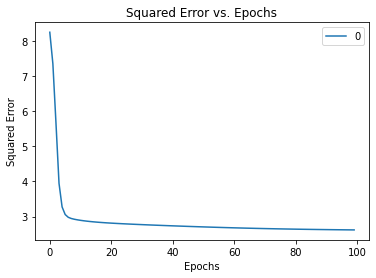

In [ ]:
my_error = pd.DataFrame(my_error)
my_error.plot()
plt.xlabel('Epochs')
plt.ylabel('Squared Error')
plt.title('Squared Error vs. Epochs')
plt.show()

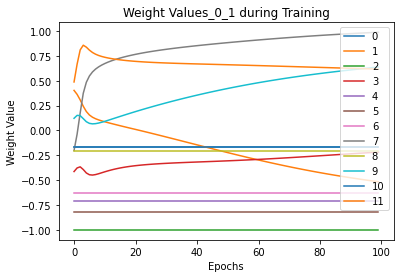

In [ ]:
# weights_0_1
tmp = pd.DataFrame(my_weights_0_1)
tmp.plot()
plt.xlabel('Epochs')
plt.ylabel('Weight Value')
plt.title('Weight Values_0_1 during Training')
plt.show()

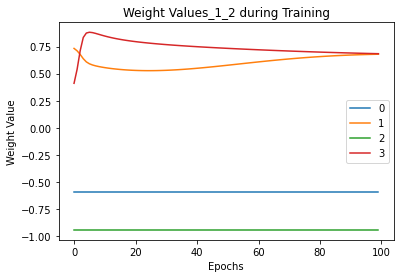

In [ ]:
# can we flatten the nested list?
tmp = pd.DataFrame(my_weights_1_2)
tmp.plot()
plt.xlabel('Epochs')
plt.ylabel('Weight Value')
plt.title('Weight Values_1_2 during Training')
plt.show()

When the loss function starts to level off (flat line)... you have converged! Using a smaller value of alpha and training for many epochs will help you train an accurate model. Note that more weights and layers don't necessarily make for a more accurate model! More on that later.

# On Your Own

**On Your Own:** See if you can add another hidden layer to this code. Don't forget ReLU!

**On Your Own:** Try to add a sigmoid activation function at the end to constraint your output between 0 and 1 (this is a really good idea for classification problems!)

# Summary
We can compute the relationship between our error and any one of our weights so that we know how changing the weight changes the error. We can then use this to reduce our error down to 0.

Adjusting our weights to reduce our error over a series of training examples ultimately just searches for correlation between our input and our output layers.

Neural networks look for correlation between input and output and you no longer have to worry about how that happens. We just know that it does.
